<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple and Multiple Linear Regression from Scratch

_Authors: Kiefer Katovich (SF) and Matt Brems (DC)_

---

### Learning Objectives
- Code simple linear regression from scratch using a simple housing price dataset
- Understand and code the loss function MSE in regression
- Write functions to calculate the R^2 metric
- Understand what R^2 represents
- Plot the regression line and predictions against the true values
- Understand the difference between multiple linear regression and simple linear regression
- Derive the beta coefficients in MLR using linear algebra
- Construct an MLR, calculate the coefficients manually, and evaluate the R^2

### Lesson Guide
- [Load the real estate data](#load-data)
- [Build a simple linear regression](#build-slr)
    - [Define the target and predictor variables](#target-predictor)
    - [Code prediction function](#pred-func)
    - [Code regression plotting function](#plot-regline)
    - [Code function to calculate residuals](#calc-resids)
    - [Code function to calculate SSE](#calc-sse)
    - [Minimize the SSE](#minimize-sse)
- [R2: the coefficient of determination](#r2)
- [From SLR to MLR](#slr-to-mlr)
- [Assumptions of MLR](#assumptions)
- [Fitting a MLR](#fit-mlr)
    - [Deriving the MLR coefficients with linear algebra](#mlr-beta-derivation)
    - [Code the MLR fit](#code-mlr)
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='load-data'></a>

## Load the real estate data

---

Over the course of this lesson we will be constructing a simple linear regression and then extend this to multiple linear regression. Included in the datasets folder is a very simple dataset on real estate prices.

**Load the data using pandas.**

In [2]:
house_csv = '../datasets/housing-data.csv'

house = pd.read_csv(house_csv)
house.head()

,sqft,bdrms,age,price
0,2104,3,70,399900
1,1600,3,28,329900
2,2400,3,44,369000
3,1416,2,49,232000
4,3000,4,75,539900


The columns are:

    sqft: the size of the house in sq. ft
    bdrms: number of bedrooms
    age: age in years of house
    price: the price of the house
    
**Convert `price` to be in units of 1000 (thousands of dollars).**

In [3]:
house['price'] = house.price.map(lambda x: x/1000.)
house.head(2)

,sqft,bdrms,age,price
0,2104,3,70,399.9
1,1600,3,28,329.9


<a id='build-slr'></a>

## Build a SLR: estimating `price` with `sqft`

---

We will start by constructing the simple linear regression. Below is the formulation for the SLR and our specific model of interest:

### $$ y = \beta_0 + \beta_1 x + \epsilon \\
\text{price} = \beta_0 + \beta_1 \text{sqft} + \epsilon$$

> $\beta_0$: the intercept

Without the intercept term the regression line would always have to pass through the origin, which is almost never an optimal way to represent the relationship between our target and predictor variable.

> $\beta_1$: the coefficient on $x$ 

We intend to estimate the values of $y$ from $x$. Each value of $x$ is multiplied by the same coefficient, which is why linear regression models model a _linear_ relationship between our predictor and target variable.

Recall that a 1 unit increase in $x$ will correspond to a $\beta_1$ unit increase in $y$ according to our model.

> $\epsilon_1$: the error (residuals)

This is the difference between the predicted and true values that are unexplained by $x$ in the regression.

---

<a id='target-predictor'></a>

### Define the target and predictor variables

Extract the target variable and predictor variable from our pandas dataframe. Classically, target and predictor are referred to dependent and independent variables. There are many different terms for what $x$ and $y$ represent.

In [4]:
# target
price = house.price.values
# predictor
sqft = house.sqft.values

<a id='pred-func'></a>

### Build a function to predict $\hat{y}$ given $x$

Build a function to represent the formula below:

### $$\hat{y} = \beta_0 + \beta_1 x$$

**Note:** I have removed the error term from the equation. Obviously we do not know the error or we would be able to model $y$ perfectly. We can assume that our prediction $\hat{y}$ is an imperfect estimation of $y$.

In [5]:
def calculate_yhat(x, b0, b1):
    return b0 + b1*x

<a id='plot-regline'></a>

### Write a function to plot a regression line

Your function should:
- Accept $\beta_0$, $\beta_1$, $x$, and $y$ as arguments
- Calculate the predicted values $\hat{y}$ given $x$ (using the function you wrote above)
- Plot the original points
- Plot the predicted points (in a different color)
- Plot the regression line defined by the slope and intercept




In [6]:
def plot_regression(x, y, b0, b1):
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca()
    # Predictive Function
    yhat = calculate_yhat(x, b0, b1)
    # y-true
    ax.scatter(x, y, color='steelblue', s=70)
    # y-pred
    ax.scatter(x, yhat, color='darkred', s=70, alpha=0.3)
    
    min_x, max_x = np.min(x), np.max(x)
    min_yhat = calculate_yhat(min_x, b0, b1)
    max_yhat = calculate_yhat(max_x, b0, b1)
    
    # plots trend line
    ax.plot([min_x, max_x], [min_yhat, max_yhat], color='darkred',
            linewidth=2.0, alpha=0.7)
    
    plt.show()


**Use your function with $\beta_0 = 0$ and $\beta_1 = 1$.**

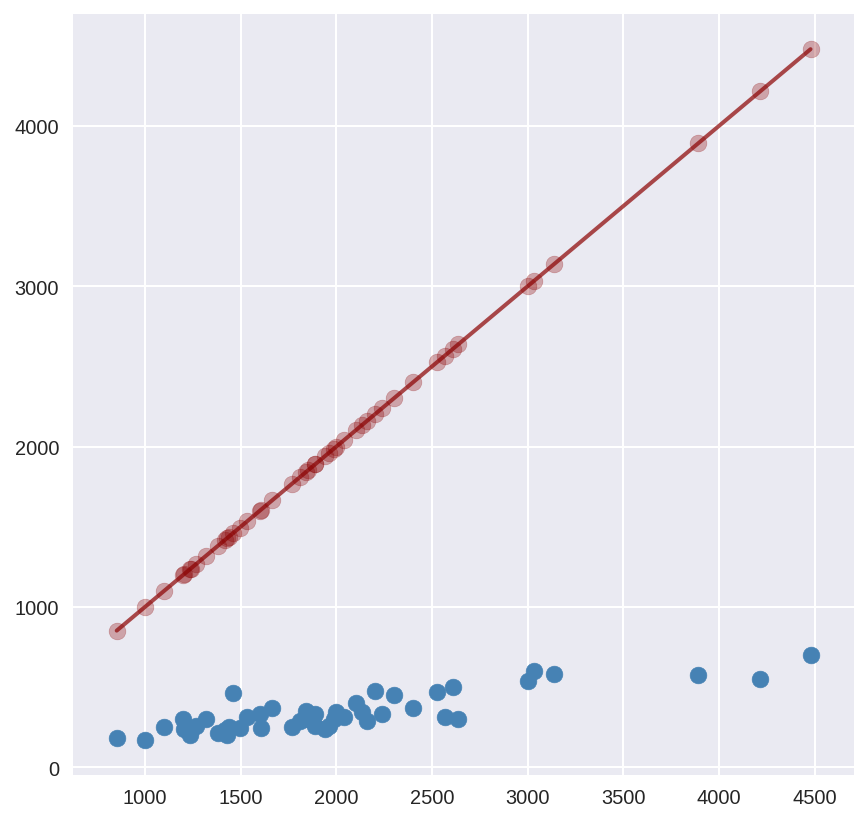

In [7]:
b0 = 0
b1 = 1
plot_regression(sqft, price, b0, b1)

<a id='calc-resids'></a>

### Write a function to calculate residuals

Recall that the residuals are simply the error of the model:

### $$ \text{residual}_i = y_i - \hat{y}_i$$

Where $y_i$ is the true value of our target at this observation $i$, and $\hat{y}_i$ is the predicted value of our target. Simple enough. 

In [8]:
def calculate_residuals(y, yhat):
    return y - yhat

<a id='calc-sse'></a>

### Write a function to calculate the sum of squared errors (SSE)

Simple linear regression can use "ordinary least squares" method for identifying linear relations between variables. Here the ["least squares"](https://www.mathworks.com/help/optim/ug/least-squares-model-fitting-algorithms.html) means that it _minimizes the sum of the squared residuals._


> **Aside:** Why the squared residuals instead of just the absolute value of the residuals? Well, both can be used – absolute value of residuals is often used when there are large outliers or other abnormalities in variables. [Solving for the least absolute deviations (LAD)](https://en.wikipedia.org/wiki/Least_absolute_deviations) is a type of "robust" regression.


In [9]:
def sum_sq_errors(errors):
    return np.sum(errors**2)

**Calculate the sum of squared errors from your initial regression with $\beta_0 = 0$ and $\beta_1 = 1$ using the functions we defined earlier.**


In [11]:
price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

151509353.472


**Choose a new $\beta_0$ and $\beta_1$ you think might be better, and calculate the SSE.**

*Given our previous graph our y value (price) appears to exists between 100 thousand and 800 thousand. Lets use 100 as $\beta_0$.* 

*Square footage values appears to exist between 500 and 4500.
By dividing the price range by the sq footage range we can estimate how much price increases when square footage increases.  $\beta_1$ in this situation.*

In [12]:
700.0/4000

0.175

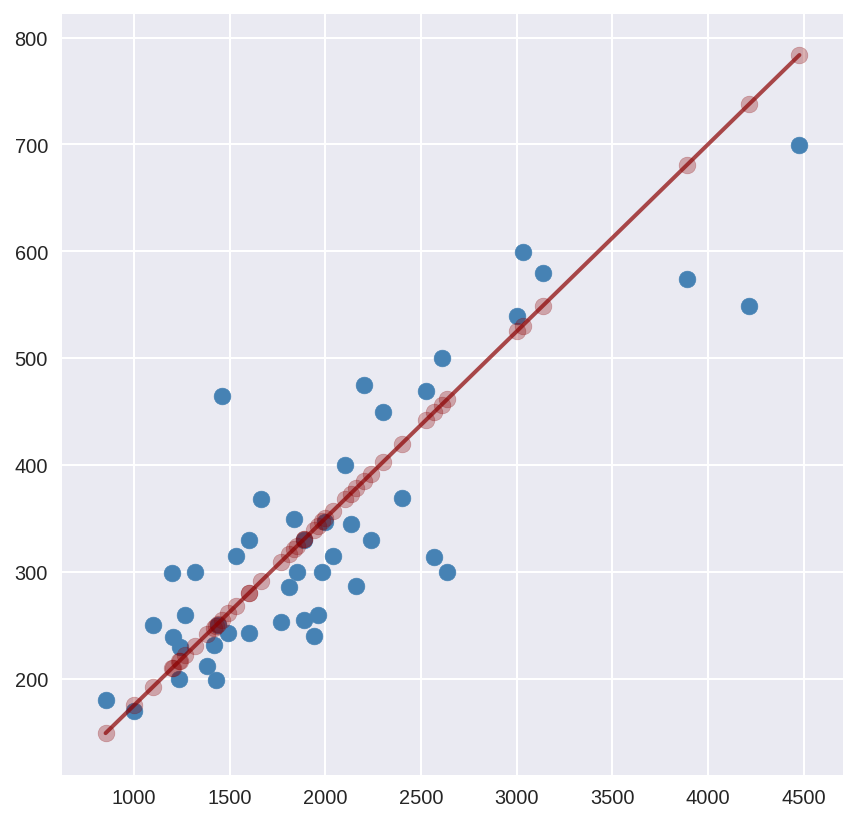

245484.672007


In [13]:
db0 = 100
b1 = 0.175

plot_regression(sqft, price, b0, b1)

price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

<a id='minimize-sse'></a>

### Minimizing the sum of squared errors

Deriving the equation that minimizes the sum of squared errors in simple linear regression can be done using calculus. [See here](http://web.cocc.edu/srule/MTH244/other/LRJ.PDF) or [here](https://en.wikipedia.org/wiki/Simple_linear_regression) for descriptions of the derivation.

For those familiar with calculus: **set the derivative of the loss function to 0 and solve for $\beta_0$ and $\beta_1$.** The loss function is "convex" and therefore it is at its minimum where the derivative is 0. Solving involves taking the partial derivatives for $\beta_0$ and $\beta_1$. 

The equations for the $\beta_0$ and $\beta_1$ that minimize the sum of squares are:

### $$ \beta_1 = \frac{\sum_{i=1}^n (y_i - \bar{y} ) (x_i - \bar{x} )}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

and

### $$ \beta_0 = \bar{y} - \beta_1\bar{x} $$

where $\bar{x}$ and $\bar{y}$ are the sample means of $x$ and $y$, respectively.

#### Write functions below to calculate $\beta_0$ and $\beta_1$ based on these equations.

In [14]:
def calc_beta_one(x, y):
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    numerator = np.sum((y - mean_y)*(x - mean_x))
    denominator = np.sum((x - mean_x)**2)
    
    return numerator/denominator

    
def calc_beta_zero(x, y, b1):
    
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    return mean_y - b1*mean_x

**Calculate the optimal $\beta_1$ and $\beta_0$ using your functions.**

In [15]:
b1 = calc_beta_one(sqft, price)
b0 = calc_beta_zero(sqft, price, b1)
print(b1, b0)

0.13452528772 71.2704924487


**Plot the regression with the optimal betas and calculate the SSE.**

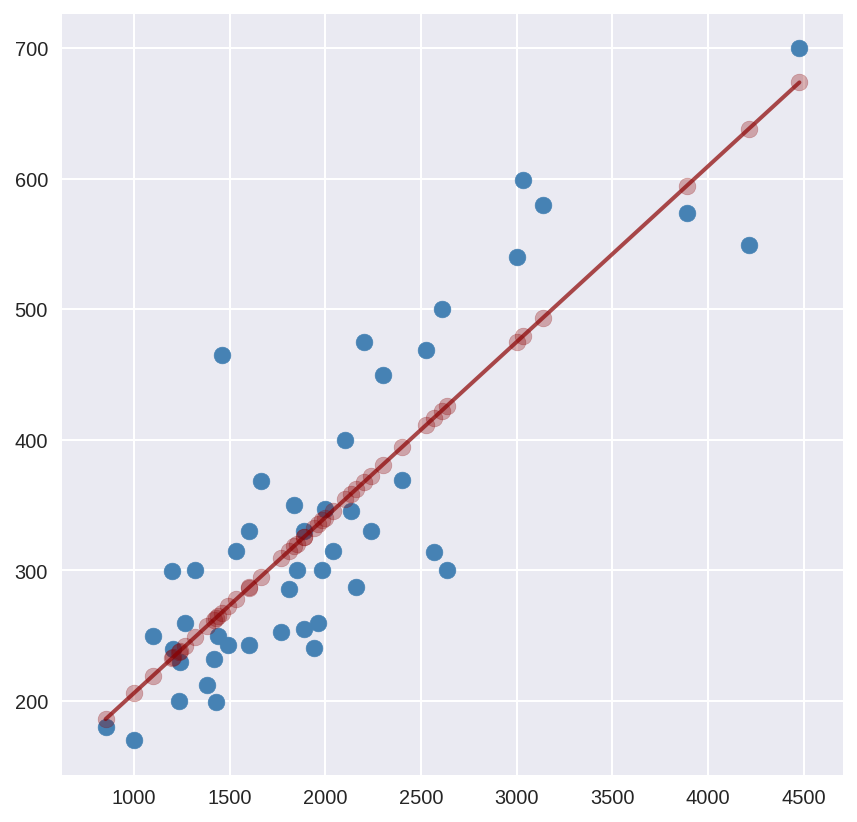

193464.477601


In [16]:
plot_regression(sqft, price, b0, b1)

price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

<a id='r2'></a>

## $R^2$: the "coefficient of determination"

---

> **$R^2$ is the amount of variance explained above baseline in your target $y$ by predictor $x$**.

It is comprised of two parts: the **total sum of squares** and the **residual sum of squares**.

The total sum of squares is defined:

### $$ SS_{tot} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2 $$

The residual sum of squares you are already familiar with. It is defined:

### $$ SS_{res} = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 $$

$R^2$ is then calculated:

### $$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

The total sum of squares is the **baseline model**: the amount of variance in $y$ we would explain if we were to predict each point of $y$ with just the mean of $y$, $\bar{y}$.

This is equivalent to estimating $y$ by fitting a regression with nothing but the intercept term $\beta_0$, which becomes the mean of $y$ (the best possible estimator of $y$ using a single value):

### $$ \hat{y} = \beta_0 = \bar{y} $$

 

As the quotient of the the $SS_{res}$ and $SS_{tot}$ decreases, the $R^2$ value gets closer to 1. While the maximum $R^2$ is 1, an $R^2$ can be infinitely negative as well.  Having a negative $R^2$ indicates that your predictive equation has greater error than the baseline mode.  

_In other words, your equation is worse at representing the relationship than a horozontal line through the Y intercept._

#### Plot your regression again, with a new regression line representing the baseline model.

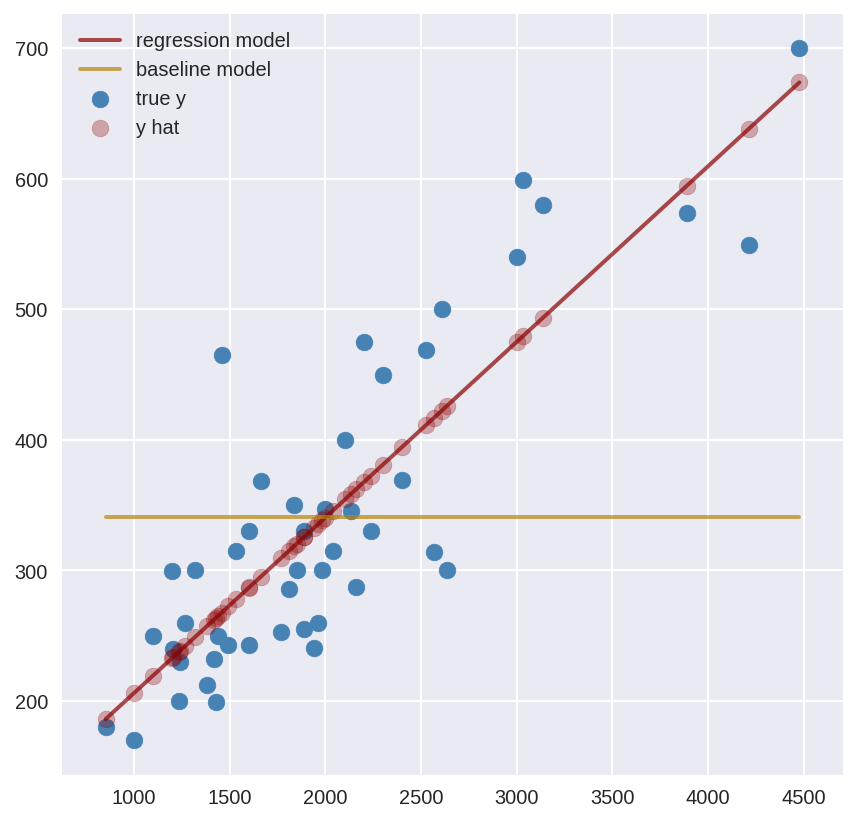

In [17]:
def estimate_betas(x, y):
    b1 = calc_beta_one(x, y)
    b0 = calc_beta_zero(x, y, b1)
    return b0, b1

def plot_regression_wbaseline(x, y, b0, b1):
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca()
    # predictive function
    yhat = calculate_yhat(x, b0, b1)
    ymean = np.mean(y)
    # y-true
    ax.scatter(x, y, color='steelblue', s=70, label='true y')
    # y-pred
    ax.scatter(x, yhat, color='darkred', s=70, alpha=0.3, label='y hat')
    
    min_x, max_x = np.min(x), np.max(x)
    min_yhat = calculate_yhat(min_x, b0, b1)
    max_yhat = calculate_yhat(max_x, b0, b1)
    # y-pred trend line
    ax.plot([min_x, max_x], [min_yhat, max_yhat], color='darkred',
            linewidth=2.0, alpha=0.7, label='regression model')
    # y-intercept
    ax.plot([min_x, max_x], [ymean, ymean], color='darkgoldenrod',
            linewidth=2.0, alpha=0.7, label='baseline model')
    
    plt.legend(loc='upper left')
    
    plt.show()

b0, b1 = estimate_betas(sqft, price)
plot_regression_wbaseline(sqft, price, b0, b1)

**Calculate the SSE for the baseline model and for the model with predictor `sqft`.**

In [18]:
def calculate_sse(x, y, b0, b1):
    yhat = calculate_yhat(x, b0, b1)
    residuals = calculate_residuals(y, yhat)
    sse = sum_sq_errors(residuals)
    return sse

print('Regression SSE:', calculate_sse(sqft, price, b0, b1))
print('Baseline SSE:', calculate_sse(sqft, price, np.mean(price), 0))

Regression SSE: 193464.477601
Baseline SSE: 719208.918475


#### Write a function to calculate $R^2$. Print out the $R^2$ of your model.

In [20]:
def calculate_r2(y, yhat):
    # estimated error 
    err_tot = (y-np.mean(y))**2
    # residual error
    err_res = (y - yhat)**2
    # total sum of squares
    ss_tot = np.sum(err_tot)
    # residual sum of squares
    ss_res = np.sum(err_res)
    return 1 - (ss_res/ss_tot)

yhat = calculate_yhat(sqft, b0, b1)
print('Regression R^2:', calculate_r2(price, yhat))
print('Baseline R^2:', calculate_r2(price, np.mean(price)))

Regression R^2: 0.731003783976
Baseline R^2: 0.0


<a id='slr-to-mlr'></a>

## From simple linear regression (SLR) to multiple linear regression (MLR)

---

The TL;DF of multiple linear regression:

> Instead of using just one predictor to estimate a continuous target, we build a model with multiple predictor variables. You will be using MLR way more than SLR going forward.

These variables will be represented as columns in a matrix (often a pandas dataframe).

**Brainstorm some examples of real-world scenarios where multiple predictors would be beneficial. Can you think of cases where it might be detrimental?**

In [18]:
# If Y is a function of multiple things then it makes sense to expand the equation
# For example: predicting the weather tomorrow from pressure and temperature instead of just one of them
# MLR could be detrimental if the predictors we are including aren't relevant. Why
# include predictors in our formula that do not have a real impact: more on this later!

<a id='assumptions'></a>

## Assumptions of MLR

---

Like SLR, there are assumptions associated with MLR. Luckily, they're quite similar to the SLR assumptions.

1. **Linearity:** $Y$ must have an approximately linear relationship with each independent $X_i$.
2. **Independence:** Errors (residuals) $\epsilon_i$ and $\epsilon_j$ must be independent of one another for any $i \ne j$.
3. **Normality:** The errors (residuals) follow a Normal distribution.
4. **Equality of Variances**: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the $X_i$ predictors. (There should be no discernable relationship between the $X$ predictors and the residuals.)
5. **Independence of Predictors**: The independent variables $X_i$ and $X_j$ must be independent of one another for any $i \ne j$.

The mnemonic LINEI is a useful way to remember these five assumptions.

<a id='fit-mlr'></a>

## Fitting a multiple linear regression

---

The formula for computing the $\beta$ values in multiple regression is best done using linear algebra. We will cover the derivation, but for more depth  [these slides are a great resource](http://statweb.stanford.edu/~nzhang/191_web/lecture4_handout.pdf).

$X$ is now a _matrix_ of predictors $x_1$ through $x_i$ (with each column a predictor), and $y$ is the target vector we are seeking to estimate. There is still only 1 *estimated* variable!

### $$ \hat{y} = \beta X$$

**Note:** $\beta$ in the formula above is a *vector* of coefficients now, rather than a single value.

In different notation we could write $\hat{y}$ calculated with:

### $$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

---

<a id='mlr-beta-derivation'></a>

### Deriving the $\beta$ coefficients

$\beta$ is solved with the linear algebra formula:

### $$ \beta = (X'X)^{-1}X'y $$

Where $X'$ is the transposed matrix of original matrix $X$ and $(X'X)^-1$ is the inverted matrix of $X'X$.



The equation using true $y$ is:

### $$ y = \beta X + \epsilon $$

Again, $\epsilon$ is our vector of errors, or residuals.

We can equivalently formulate this as in terms of the residuals:

### $$ \epsilon = \beta X - y $$

Our goal is to minimize the sum of squared residuals. The sum of squared residuals is equivalent to the dot product of the vector of residuals:

### $$ \sum_{i=1}^n \epsilon_i^2 = 
\left[\begin{array}{cc}
\epsilon_1 \cdots \epsilon_n
\end{array}\right] 
\left[\begin{array}{cc}
\epsilon_1 \\ \cdots \\ \epsilon_n
\end{array}\right] = \epsilon' \epsilon
$$

Therefore we can write the sum of squared residuals as:

### $$ \epsilon' \epsilon = (\beta X - y)' (\beta X - y) $$

Which becomes:

### $$ \epsilon' \epsilon = y'y - y'X\beta - \beta' X' y + \beta' X' X \beta $$

Now take the derivative with respect to $\beta$:

### $$ \frac{\partial \epsilon' \epsilon}{\partial \beta} = 
-2X'y + 2X'X\beta$$

We want to minimize the sum of squared errors, and so we set the derivative to zero and solve for the beta coefficient vector:

### $$ 0 = -2X'y + 2X'X\beta \\
X'X\beta = X'y \\
\beta = (X'X)^{-1}X'y$$

<a id='code-mlr'></a>

### Code a MLR

**First, we need to create the "design matrix" of our predictors.**

The first column will be a column of all 1s (the intercept) and the other columns will be `sqft`, `bdrms`, and `age`.

This is easiest to do with pandas: add a column for the intercept first, then extract the matrix using with `.values`.

In [26]:
house.head()

,sqft,bdrms,age,price
0,2104,3,70,399.9
1,1600,3,28,329.9
2,2400,3,44,369.0
3,1416,2,49,232.0
4,3000,4,75,539.9


In [22]:
X = house[['sqft', 'bdrms', 'age']]
X['intercept'] = 1.
# reordering columns:
X = X[['intercept', 'sqft', 'bdrms', 'age']].values
print(X[0:3, :])

[[  1.00000000e+00   2.10400000e+03   3.00000000e+00   7.00000000e+01]
 [  1.00000000e+00   1.60000000e+03   3.00000000e+00   2.80000000e+01]
 [  1.00000000e+00   2.40000000e+03   3.00000000e+00   4.40000000e+01]]


### Solve for the beta coefficients

We are still predicting `price`. Implement the linear algebra equation to solve for the beta coefficients. 

### $$ \beta = (X'X)^{-1}X'y $$

**Tips:**

The transpose of a matrix is calculated by appending `.T` to the matrix:

    X.T

Matrices multipled in the formula should be done with the "dot product":

    np.dot(mat1, mat2)

Inverting a matrix is done using:

    np.linalg.inv()

In [24]:
beta_vec = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), price)
print(beta_vec)

[  9.24516278e+01   1.39334847e-01  -8.62147046e+00  -8.12178776e-02]


**Confirm that these betas are the same as the ones using `sklearn.linear_model.LinearRegression`**

```python
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, price)

print linreg.coef_
```

In [25]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, price)

print(linreg.coef_)

[  9.24516278e+01   1.39334847e-01  -8.62147046e+00  -8.12178776e-02]


**Calculate predicted $\hat{y}$ with your $X$ predictor matrix and $\beta$ coefficients.**

In [26]:
yhat = np.dot(X, beta_vec)

**Calculate the $R^2$ of the multiple regression model.**

In [31]:
print 'Multiple regression R^2:', calculate_r2(price, yhat)

Multiple regression R^2: 0.733163999069


<a id='additional-resources'></a>

## Additional resources

---

[Maximum likelihood estimation](https://onlinecourses.science.psu.edu/stat504/node/28)